# Fully-convolutional QRNN

This notebooks provides a simple, synthetic example to test and illustrate the use of a UNet-type network architecture as a QRNN.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Training data

The input data consists of greyscale images and the output is just
the magnitude of the image gradients. The output is corrupted using heteroscedastic,
Gaussian noise whose standard deviation is $10\%$ of the absolute pixel value.

In [3]:
from scipy.signal import convolve

def create_data(n):
    w = 64
    kw = 21

    # Input data: Smooth random field.
    k = np.linspace(-3, 3, kw)
    k = np.exp(-np.sqrt((k ** 2).reshape(1, 1, -1, 1) + (k ** 2).reshape(1, 1, 1, -1)))
    k /= k.sum()

    x = np.random.normal(size=(n, 1, w + kw + 1, w + kw + 1))
    x = convolve(x, k, mode="valid")

    # Compute gradients
    kx = 0.5 * np.array([-1, 0, 1]).reshape(1, 1, 1, 3)
    ky = 0.5 * np.array([-1, 0, 1]).reshape(1, 1, 3, 1)
    dx = convolve(x, kx, mode="valid")[:, :, 1:-1, :]
    dy = convolve(x, ky, mode="valid")[:, :, :, 1:-1]
    m =  np.sqrt(dx ** 2 + dy ** 2)

    # Add noise
    x = x[:, :, 1:-1, 1:-1]
    y = m + 0.1 * x * np.random.normal(size=m.shape)
    return x, y

In [22]:
x, y = create_data(10000)

In [25]:
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
def plot_data(x, y, n = 4):
    f = plt.figure(figsize = (n * 4, 8))
    gs = GridSpec(n + 1, 2, height_ratios = [1.0] * n + [0.1])
    norm_x = Normalize(-0.2, 0.2)
    norm_y = Normalize(-0.05, 0.05)
    
    for i in range(n):
        ind = np.random.randint(x.shape[0])
        ax1 = plt.subplot(gs[i, 0])
        img1 = ax1.matshow(x[ind, 0], norm=norm_x)
        ax2 = plt.subplot(gs[i, 1])
        img2 = ax2.matshow(y[ind, 0], norm=norm_y)
        
        if i == 0:
            ax1.set_title("Input", pad=20)
            ax2.set_title("Output", pad=20)
        
    cax1 = plt.subplot(gs[-1, 0])
    plt.colorbar(img1, cax=cax1, orientation="horizontal")
    
    cax2 = plt.subplot(gs[-1, 1])
    plt.colorbar(img2, cax=cax2, orientation="horizontal")
    
    plt.tight_layout()
    return f

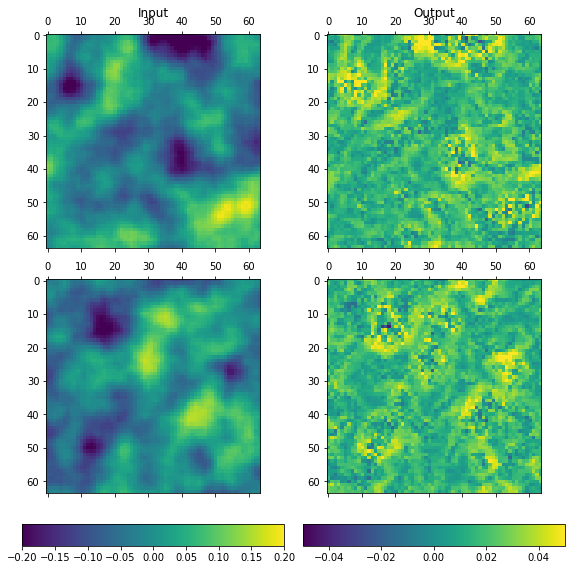

In [26]:
f = plot_data(x, y, 2)

# Training

In [27]:
from typhon.retrieval.qrnn import QRNN
from typhon.retrieval.qrnn.models.pytorch import UNet
skip_connection = "all"
quantiles = np.array([0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95])
unet = UNet(1, quantiles, skip_connection=skip_connection)
qrnn = QRNN(1, model=unet)

In [ ]:
training_data = (x, y)
qrnn.train(training_data, batch_size=8, maximum_epochs=10, momentum=0.99, gpu=False)
qrnn.train(training_data, batch_size=8, gpu=False)

In [31]:
if skip_connection is None:
    qrnn.save("../../models/unet.mdl")
else:
    qrnn.save("../../models/unet_skip_{}.mdl".format(skip_connection))

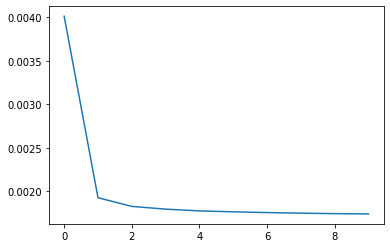

In [32]:
plt.plot(qrnn.model.training_errors)


# Validation

In [33]:
x, y = create_data(1)
y_pred = qrnn.predict(x)

In [34]:
y_pred.shape

(1, 11, 64, 64)

In [35]:
qrnn.quantiles

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.5 , 0.55, 0.65, 0.75, 0.85, 0.95])

In [36]:
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
def plot_result(x, y, y_pred):
    f = plt.figure(figsize = (16, 4))
    gs = GridSpec(1, 4, height_ratios = [1.0])
    norm = Normalize(-0.05, 0.05)
    
    ax1 = plt.subplot(gs[0])
    ax1.matshow(y[0, 0], norm = norm)
    
    ax2 = plt.subplot(gs[1])
    ax2.matshow(np.abs(2.0 * 0.1 * x[0, 0]), norm = norm)
    
    ax3 = plt.subplot(gs[2])
    ax3.matshow(y_pred[0, 5], norm = norm)
    
    ax4 = plt.subplot(gs[3])
    ax4.matshow(0.7/0.68 * (y_pred[0, -2] - y_pred[0, 1]), norm = norm)
    
    return f

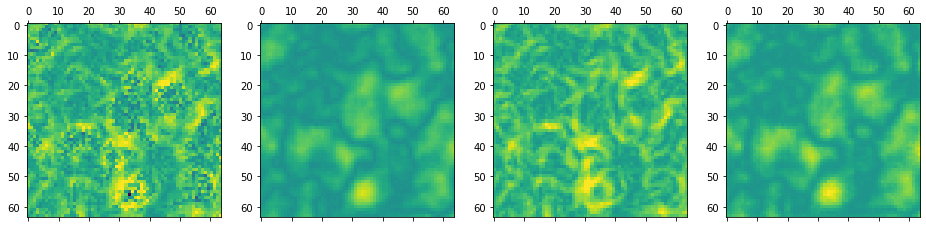

In [37]:
f = plot_result(x, y, y_pred)